*First compiled: May 1, 2017. Updated Mar 28, 2018.*   
See the same notebook for Scanpy [0.4.4](https://github.com/theislab/scanpy_usage/blob/17c34b61f76de79bfdea7512f1782bf3f5ecb160/170501_moignard15/moignard15.ipynb).

# DPT for hematopoiesis in mouse [(Moignard *et al.*, 2015)](http://dx.doi.org/10.1038/nbt.3154)

The following analysis has been published by [Haghverdi *et al.*, Nat. Meth. (2016)](http://dx.doi.org/10.1038/nmeth.3971) together with a Matlab implementation of Diffusion Pseudotime. The data is from [Moignard *et al.*, Nat. Biotechn. (2015)](http://dx.doi.org/10.1038/nbt.3154).

In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
results_file = './write/moignard15.h5ad'

scanpy==1.0 anndata==0.5.8 numpy==1.14.1 scipy==1.0.0 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


This is single-cell qPCR data. It's already on a logrithmic scale and pretty low-dimensional. We do not have to perform extensive preprocessing.

1. Filter out a few genes.
2. Choose a 'root cell'.                                                                                                                                                           
3. Define groupnames by inspecting cellnames.                                                                                                                                    

In [2]:
filename = 'data/moignard15/nbt.3154-S3.xlsx'
# the url is used to download the file if it's not there yet
backup_url = 'http://www.nature.com/nbt/journal/v33/n3/extref/nbt.3154-S3.xlsx'
adata = sc.read(filename, sheet='dCt_values.txt', cache=True, backup_url=backup_url)
# filter out genes as done by Haghverdi et al. (2016)
gene_subset = ~np.in1d(adata.var_names, ['Eif2b1', 'Mrpl19', 'Polr2a', 'Ubc'])
# get a new AnnData object retain non-removed genes
adata = adata[:, gene_subset]
# choose root cell as in Haghverdi et al. (2016)
adata.uns['iroot'] = 532  # note that in Matlab/R, counting starts at 1
# annotate with Moignard et al. (2015) experimental cell groups
groups_names = ['HF', 'NP', 'PS', '4SG', '4SFG']
# annotate each sample/cell
adata.obs['exp_groups'] = [
    next(gname for gname in groups_names if sname.startswith(gname))
    for sname in adata.obs_names]
# make this a categorical column in the dataframe
adata.obs['exp_groups'] = pd.Categorical(adata.obs['exp_groups'],
                                         categories=groups_names)
# set the colors of names in "groups"
adata.uns['exp_groups_colors'] = ['#D7A83E', '#7AAE5D', '#497ABC', '#AF353A', '#765099']

... reading from cache file ./cache/data-moignard15-nbt.3154-S3.h5ad


Compute the neighborhood relations of single cells.

In [3]:
sc.pp.neighbors(adata, n_neighbors=5, method='gauss', knn=False)

computing neighbors
    using data matrix X directly
    finished (0:00:01.65) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


Compute branchings and diffusion pseudotime using DPT.

In [4]:
sc.tl.dpt(adata, n_branchings=1)

performing Diffusion Pseudotime analysis
    initialized `.distances` `.connectivities` 
    eigenvalues of transition matrix
    [1.0000018  0.99249375 0.9739005  0.8865169  0.8607167  0.82551247
     0.7805156  0.7599625  0.73387116 0.73009884]
    finished (0:00:07.00) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs)


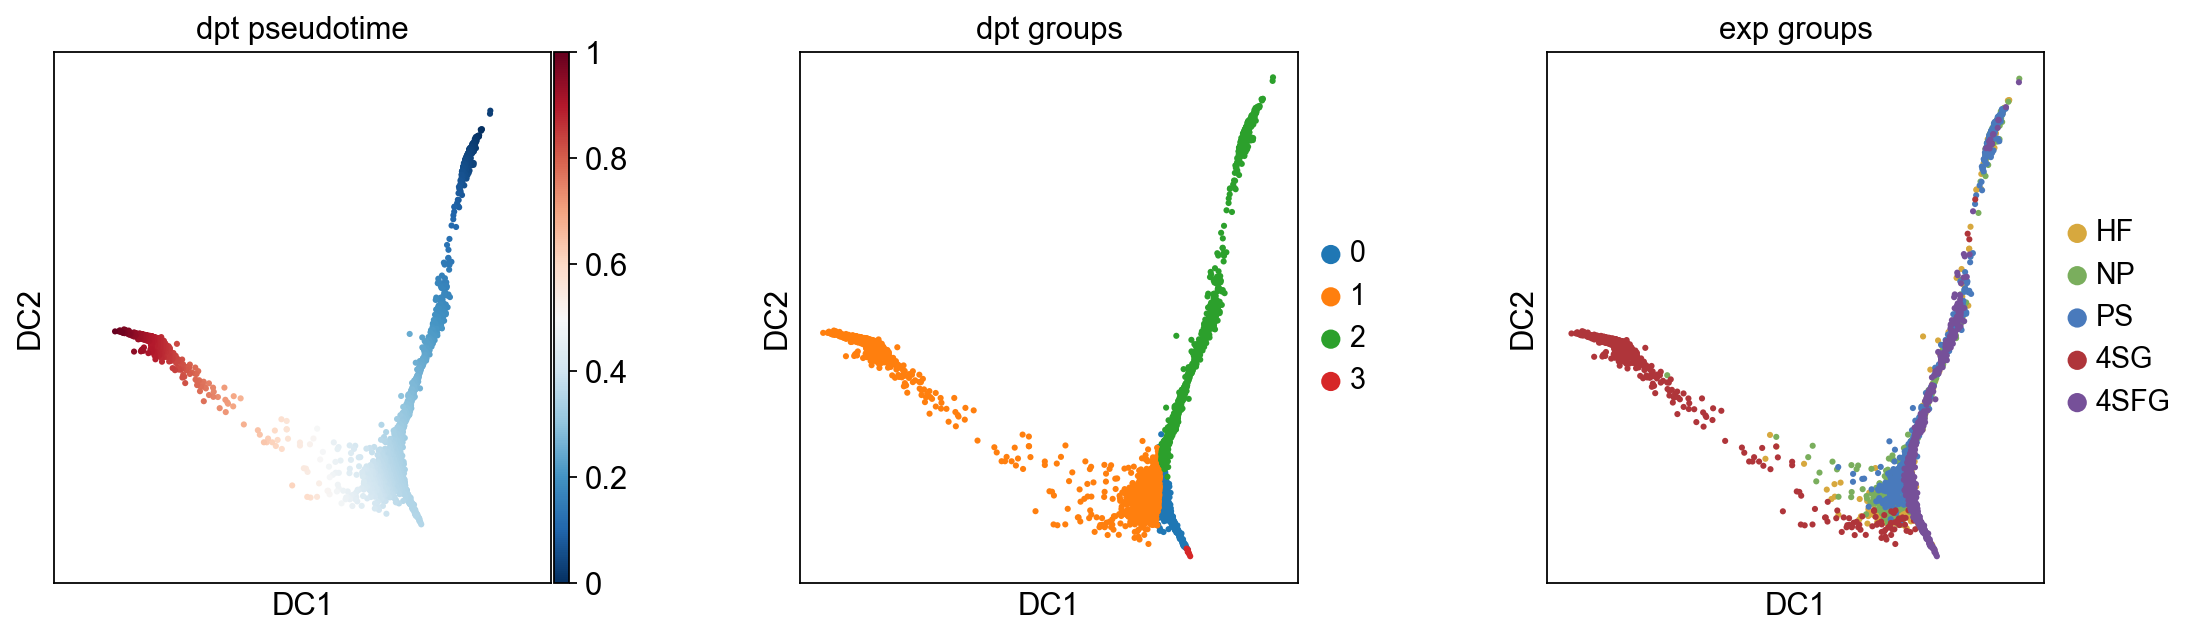

In [5]:
sc.pl.diffmap(adata, color=['dpt_pseudotime', 'dpt_groups', 'exp_groups'])

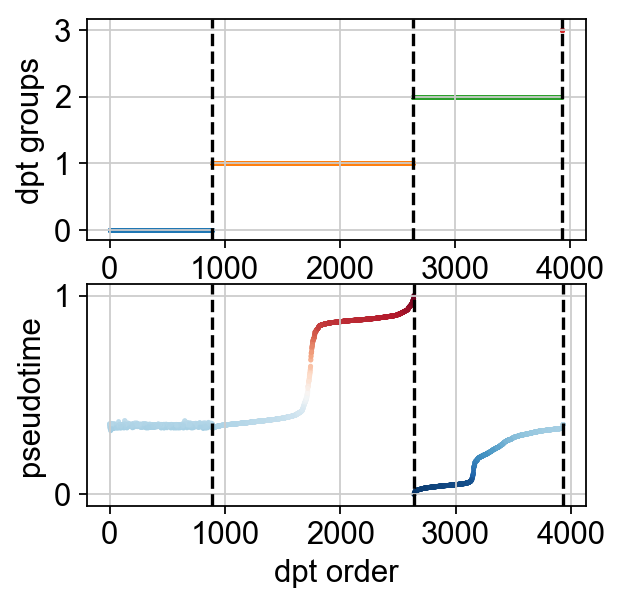

In [6]:
sc.pl.dpt_groups_pseudotime(adata)

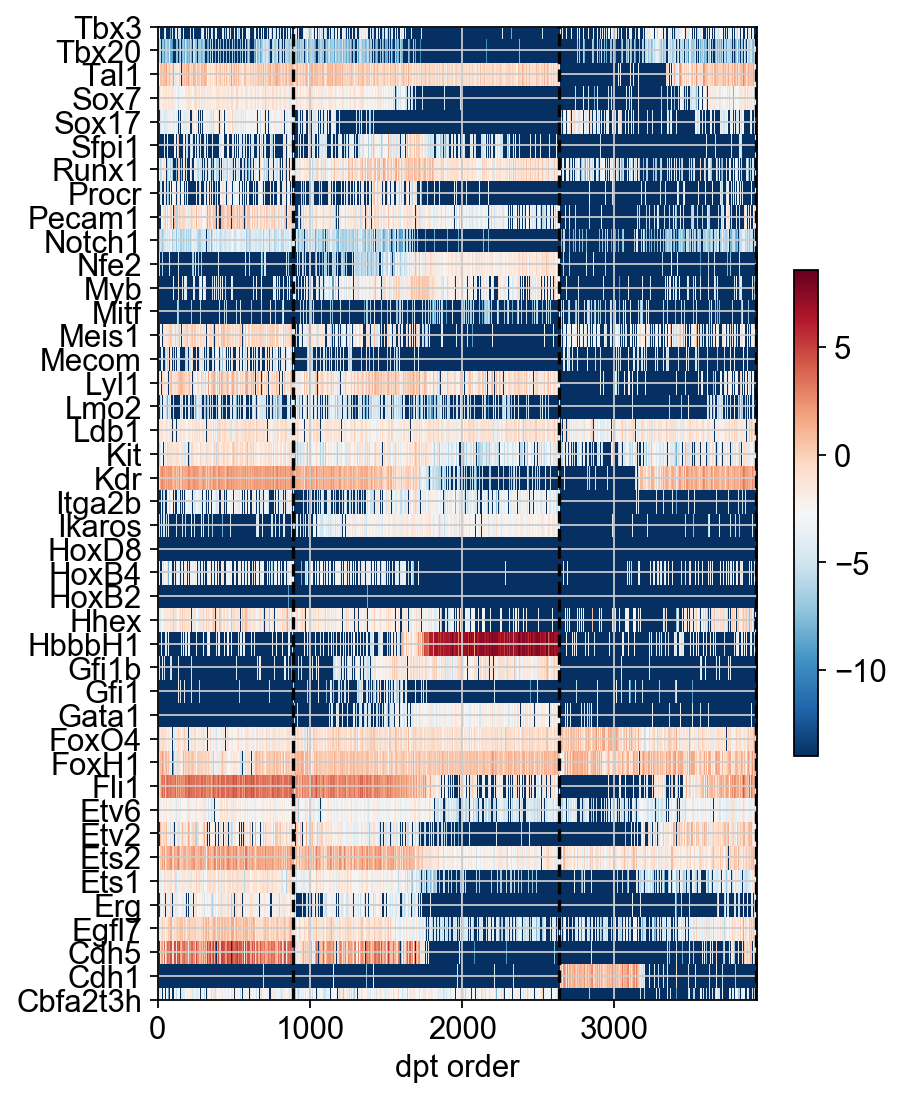

In [7]:
sc.pl.dpt_timeseries(adata)

Let us annotate the cell groups as follows.

In [8]:
adata.obs['dpt_groups'].cat.categories = [
    'undecided/endothelial', 'erythrocytes', 'trunk', 'endothelial']

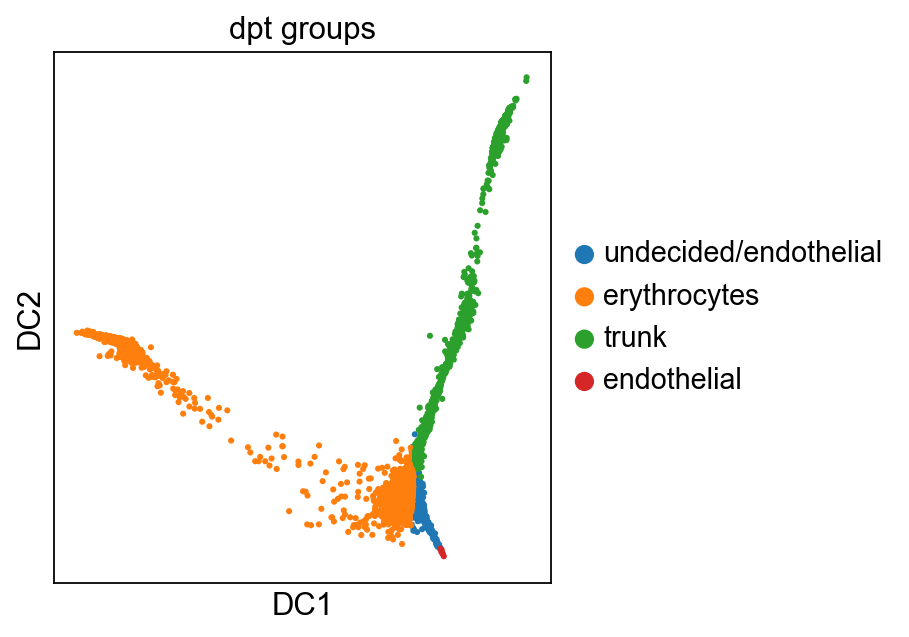

In [9]:
sc.pl.diffmap(adata, color='dpt_groups')

Save the results.

In [10]:
adata.write(results_file)

Or as csv.

In [11]:
# adata.obs.to_csv('./write/annotation.csv')

In [12]:
# To write the full object to csvs
# adata.write_csvs('./write/moignard15.csv')